# Mixture Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc as pm
import scipy.stats as stats

Let's suppose that there are two random variables, $x_1$ and $x_2$, following two normal distributions, respectively:
$$
x_1 \sim \mathcal{N}(3,2^2)\\
x_2 \sim \mathcal{N}(\text{-}3,1^2)
$$

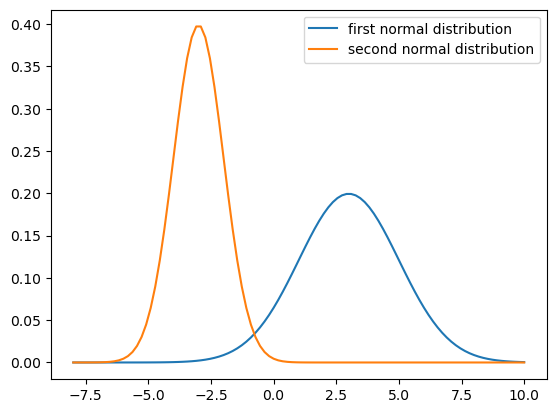

In [2]:
plt.plot(np.linspace(-8,10,100), stats.norm.pdf(np.linspace(-8,10,100), loc=3, scale=2), label='first normal distribution')
plt.plot(np.linspace(-8,10,100), stats.norm.pdf(np.linspace(-8,10,100), loc=-3, scale=1), label='second normal distribution')
plt.legend()
plt.show()

Let's draw 100 samples from each distribution. The set of 200 samples is our dataset in this example.

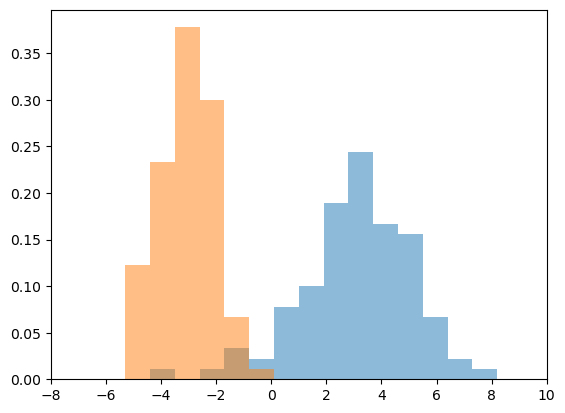

In [3]:
np.random.seed(1234) # for reproducibility
x1 = np.random.randn(100)*2+3 # first distribution, mean:3, std:2
x2 = np.random.randn(100)*1-3 # second distribution, mean:-3, std:1
plt.hist(x1, density=True, alpha=0.5, bins=20, range=(-8,10))
plt.hist(x2, density=True, alpha=0.5, bins=20, range=(-8,10))
plt.xlim(-8,10)
plt.show()

Assume that we do not know the two distributions a priori. Now, we want to fit a normal distribution (estimating $\mu$ and $\sigma$) to our dataset.

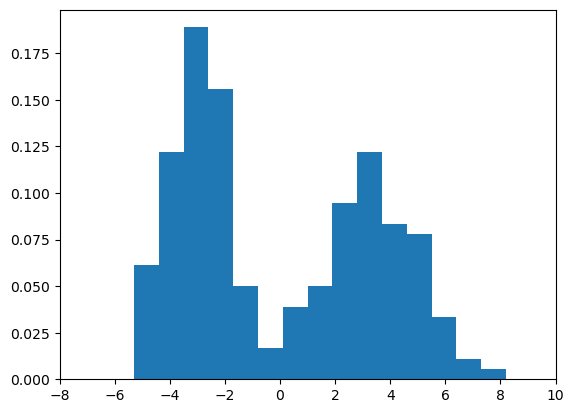

In [4]:
All = np.hstack((x1,x2))
plt.hist(All, density=True, bins=20, range=(-8,10))
plt.xlim(-8,10)
plt.show()

Let's construct our model. Again, all we want is estimating $\mu$ and $\sigma$

In [6]:
model_all = pm.Model()
with model_all:
    mu = pm.Normal('mu', mu=0, sigma=10) # mu
    std = pm.Exponential('std', lam=1/10.) # sigma
    obs = pm.Normal('obs', mu=mu, sigma=std, observed=All) # likelihood, normal distribution
    trace = pm.sample(draws=2000,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, std]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.


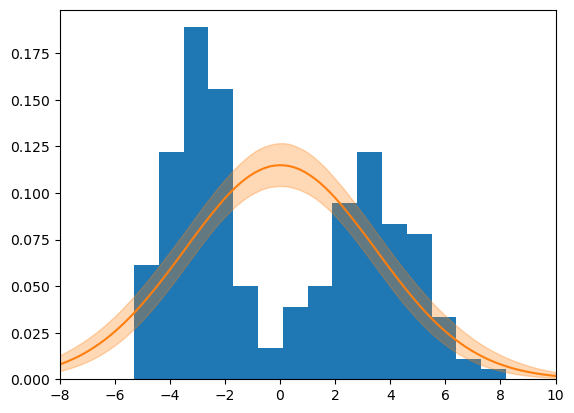

In [9]:
mu_sample = trace.posterior['mu'].to_numpy().reshape(-1,1)
std_sample = trace.posterior['std'].to_numpy().reshape(-1,1)

X_plot = np.linspace(-8,10,100)

pdf = np.empty((mu_sample.shape[0],100))
for i,param in enumerate(zip(mu_sample, std_sample)):
    pdf[i,:] = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
pdf_med = np.median(pdf,axis=0)
pdf_ub = np.percentile(pdf,axis=0,q=97.5)
pdf_lb = np.percentile(pdf,axis=0,q=2.5)

plt.hist(All, density=True, bins=20, range=(-8,10),zorder=0)
plt.plot(X_plot, pdf_med,zorder=1)
plt.fill_between(X_plot, pdf_lb, pdf_ub, alpha=0.3, color='C1',zorder=2)
plt.xlim(-8,10)
plt.show()

You can see that we get one flat Normal distribution which is quite different from either of the original two distributions.<br>
How can we do better?<br>

From the histogram above, we can notice that fitting two normal distributions would be better than fitting one for all the datapoints.<br>
The problem is that, we do not know which datapoint belongs to which distribution!<br>

Even if you try to fit two normal distributions as below, you will notice that this is not a proper way. You see two overlapping normal distributions.

In [26]:
model_all = pm.Model()
with model_all:
    mu1 = pm.Normal('mu1', mu=0, sigma=10) # mu
    std1 = pm.Exponential('std1', lam=1/10.) # sigma
    obs1 = pm.Normal('obs1', mu=mu1, sigma=std1, observed=All) # likelihood, normal distribution
    mu2 = pm.Normal('mu2', mu=0, sigma=10) # mu
    std2 = pm.Exponential('std2', lam=1/10.) # sigma
    obs2 = pm.Normal('obs2', mu=mu2, sigma=std2, observed=All) # likelihood, normal distribution
    trace = pm.sample(draws=2000,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1, std1, mu2, std2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.


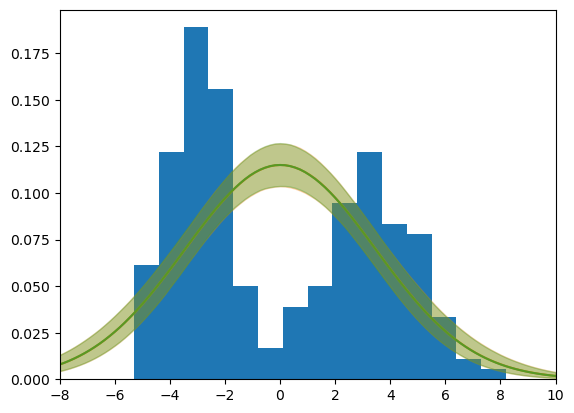

In [31]:
mu1_sample = trace.posterior['mu1'].to_numpy().reshape(-1,1)
std1_sample = trace.posterior['std1'].to_numpy().reshape(-1,1)
mu2_sample = trace.posterior['mu2'].to_numpy().reshape(-1,1)
std2_sample = trace.posterior['std2'].to_numpy().reshape(-1,1)

X_plot = np.linspace(-8,10,100)

pdf = np.empty((mu1_sample.shape[0],100))
for i,param in enumerate(zip(mu1_sample, std1_sample)):
    pdf[i,:] = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
pdf_med = np.median(pdf,axis=0)
pdf_ub = np.percentile(pdf,axis=0,q=97.5)
pdf_lb = np.percentile(pdf,axis=0,q=2.5)

plt.hist(All, density=True, bins=20, range=(-8,10),zorder=0)
plt.plot(X_plot, pdf_med,zorder=1)
plt.fill_between(X_plot, pdf_lb, pdf_ub, alpha=0.3, color='C1',zorder=2)
plt.xlim(-8,10)

pdf = np.empty((mu2_sample.shape[0],100))
for i,param in enumerate(zip(mu2_sample, std2_sample)):
    pdf[i,:] = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
pdf_med = np.median(pdf,axis=0)
pdf_ub = np.percentile(pdf,axis=0,q=97.5)
pdf_lb = np.percentile(pdf,axis=0,q=2.5)

plt.plot(X_plot, pdf_med,zorder=1)
plt.fill_between(X_plot, pdf_lb, pdf_ub, alpha=0.3, color='C2',zorder=2)
plt.xlim(-8,10)
plt.show()

To solve this probelm, we introduce a discrete variable, $z$, into our problem. We assume that, each datapoint inherently has a discrete value (either 0 or 1) that represents which distribution the datapoint belongs to. But, it's a hidden (latent/unobsevable/unmeasurable) variable.<br>

Now, we estimate $z$ for each data point as well as model parameters ($\mu_1, \mu_2, \sigma_1, \sigma_2$). Let's sample $z_{1:D}$, $\mu$'s and $\sigma$'s.

In [20]:
# log likelihood, normal distribution
def llk_norm(X, mu, tau):
    return (-tau * (X - mu)**2. + pm.math.log(tau / np.pi / 2.)) / 2.

# log liklihood with two normal distributions.
# if z=0, calculate the log likelihood with the first normal distribution, 
# if z=1, calculate the log likelihood with the second normal distribution.
def llk_mixture(mu=None, std=None, z=None, X=None):
    mu1 = mu[0]
    std1 = std[0]
    tau1 = 1./std1**2.
    llk_norm1 = llk_norm(X=X, mu=mu1, tau=tau1)[:,None]
    
    mu2 = mu[1]
    std2 = std[1]
    tau2 = 1./std2**2.
    llk_norm2 = llk_norm(X=X, mu=mu2, tau=tau2)[:,None]
    
    llk_mixture = pm.math.concatenate((llk_norm1, llk_norm2),axis=1)
    
    return pm.math.sum(llk_mixture[np.arange(X.shape[0]),z])

In [21]:
model_mixture = pm.Model()
with model_mixture:
    mu = pm.Normal('mu', mu=0, sigma=10, shape=2) # two mu's
    std = pm.Exponential('std', lam=1/10., shape=2) # two sigma's
    pi = pm.Dirichlet('pi', np.ones(2)) # you can ignore it for now
    z = pm.Categorical('z',p=pi,shape=All.shape[0]) # z values
    obs = pm.Potential('obs',llk_mixture(mu=mu, std=std, z=z, X=All)) # custom likelihood
    
    trace = pm.sample(draws=2000,tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, std, pi]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 160 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
mu_sample = trace.posterior['mu'].to_numpy().reshape(-1,1)
std_sample = trace.posterior['std'].to_numpy().reshape(-1,1)

idx = (mu_sample>0)
mu_1_sample = mu_sample[idx]
std_1_sample = std_sample[idx]
mu_2_sample = mu_sample[~idx]
std_2_sample = std_sample[~idx]

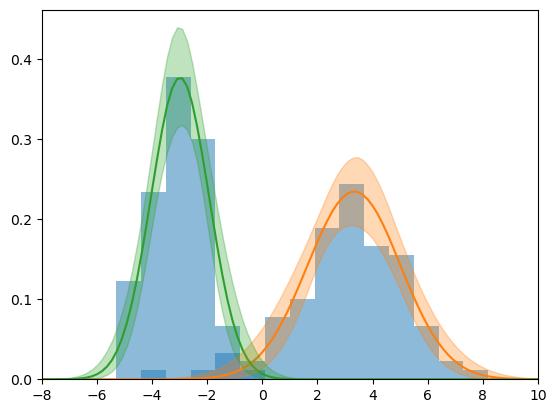

In [24]:
pdf_1 = np.empty((mu_1_sample.shape[0],100))
pdf_2 = np.empty((mu_2_sample.shape[0],100))
for i,param in enumerate(zip(mu_1_sample, std_1_sample, mu_2_sample, std_2_sample)):
    pdf_1[i,:] = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
    pdf_2[i,:] = stats.norm.pdf(x=X_plot,loc=param[2],scale=param[3])
pdf_1_med = np.median(pdf_1,axis=0)
pdf_1_ub = np.percentile(pdf_1,axis=0,q=97.5)
pdf_1_lb = np.percentile(pdf_1,axis=0,q=2.5)
pdf_2_med = np.median(pdf_2,axis=0)
pdf_2_ub = np.percentile(pdf_2,axis=0,q=97.5)
pdf_2_lb = np.percentile(pdf_2,axis=0,q=2.5)

plt.hist(x1, density=True, alpha=0.5, bins=20, range=(-8,10), color='C0')
plt.hist(x2, density=True, alpha=0.5, bins=20, range=(-8,10), color='C0')
plt.plot(X_plot, pdf_1_med,zorder=1,c='C1')
plt.fill_between(X_plot, pdf_1_lb, pdf_1_ub, alpha=0.3, color='C1',zorder=2)
plt.plot(X_plot, pdf_2_med,zorder=1,c='C2')
plt.fill_between(X_plot, pdf_2_lb, pdf_2_ub, alpha=0.3, color='C2',zorder=2)
plt.xlim(-8,10)
plt.show()

The model discovered two normal distributions! In other words, two sub-models for two groups (clusters) of data.

## Homework
So, can we do similar work with our previous data? I know it will be challenging.

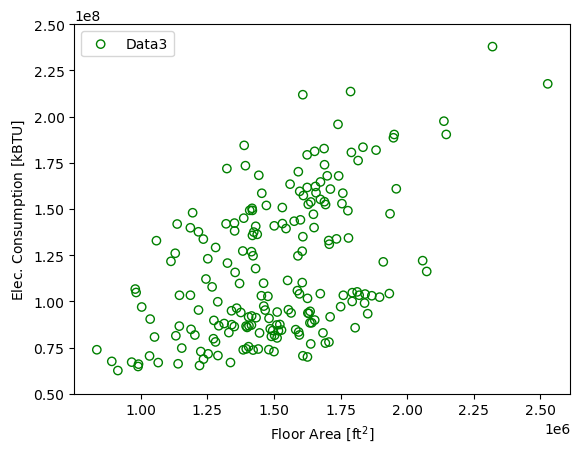

In [25]:
# import / plot data
Data3 = pd.read_excel(os.path.join(os.path.dirname('__file__'), '..', 'data', 'Data.xlsx'))

plt.scatter(Data3['Area [sq ft]'], Data3['Elec [kBTU]'], facecolors='None', edgecolors='green', label='Data3')

plt.xlabel('Floor Area [$\mathrm{ft}^2$]')
plt.ylabel('Elec. Consumption [$\mathrm{kBTU}$]')
plt.ylim(0.5e+8, 2.5e+8)
plt.legend()
plt.show()